In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
! pip install biopython
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.5 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Reading RibZero_RPKM and RPF_RPKM

In [ ]:
RiboZero_path='/content/drive/My Drive/BioInformaticsProject/GSE75897_RiboZero_RPKMs.txt'
RPF_path='/content/drive/My Drive/BioInformaticsProject/GSE75897_RPF_RPKMs.txt'
ribo_zero = pd.read_csv(RiboZero_path, sep="\t", header=None, names=["Gene", "RiboZero_RPKM"])
rpf_rpkm = pd.read_csv(RPF_path, sep="\t", header=None, names=["Gene", "RPF_RPKM"])

print(ribo_zero.shape)
# Merge datasets on Gene column
data_df = pd.merge(ribo_zero, rpf_rpkm, on="Gene")

# Calculate initiation efficiency (IE)
data_df["IE"] = data_df["RPF_RPKM"] * 200000 / 60000

data_df.head()
print(data_df.shape)

(5293, 2)
(5090, 4)


# Reading gff File (finding ORF Start/End positions, Chromosomes, and Strands for mRNA Genes)

In [ ]:
gff_path='/content/drive/My Drive/BioInformaticsProject/Saccharomyces_cerevisiae_Lin.gff'

In [ ]:
import pandas as pd

gff_df = pd.read_csv(gff_path, sep="\t", comment="#", header=None)
gff_df.columns = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]


# Swap start and end where strand is '-'
#gff_df.loc[gff_df['strand'] == '-', ['start', 'end']] = gff_df.loc[gff_df['strand'] == '-', ['end', 'start']].values

gff_df.head()




,seqid,source,type,start,end,score,strand,phase,attributes
0,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W
1,chrI,SGD,mRNA,335,649,.,+,.,ID=rna0;Parent=YAL069W
2,chrI,SGD,exon,335,649,.,+,.,ID=id1;Parent=rna0
3,chrI,SGD,CDS,335,649,.,+,0,ID=cds0;Parent=rna0
4,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A


In [ ]:
gene_dict = {}

for gene in data_df['Gene']:
    matched_rows = gff_df[gff_df['attributes'].str.contains(gene, na=False)]

    if not matched_rows.empty:
        gff_row = matched_rows.iloc[0]  # Taking the first match
        gene_dict[gene] = [gff_row['start'], gff_row['end'],gff_row['seqid'],gff_row['strand']]



print(gene_dict)




{'YAL001C': [np.int64(147594), np.int64(151166), 'chrI', '-'], 'YAL002W': [np.int64(143707), np.int64(147531), 'chrI', '+'], 'YAL003W': [np.int64(142174), np.int64(143160), 'chrI', '+'], 'YAL007C': [np.int64(137698), np.int64(138345), 'chrI', '-'], 'YAL008W': [np.int64(136914), np.int64(137510), 'chrI', '+'], 'YAL009W': [np.int64(135854), np.int64(136633), 'chrI', '+'], 'YAL010C': [np.int64(134184), np.int64(135665), 'chrI', '-'], 'YAL011W': [np.int64(132199), np.int64(134076), 'chrI', '+'], 'YAL012W': [np.int64(130799), np.int64(131983), 'chrI', '+'], 'YAL013W': [np.int64(129270), np.int64(130487), 'chrI', '+'], 'YAL014C': [np.int64(128252), np.int64(129019), 'chrI', '-'], 'YAL015C': [np.int64(126903), np.int64(128102), 'chrI', '-'], 'YAL016W': [np.int64(124879), np.int64(126786), 'chrI', '+'], 'YAL017W': [np.int64(120225), np.int64(124295), 'chrI', '+'], 'YAL018C': [np.int64(118564), np.int64(119541), 'chrI', '-'], 'YAL019W': [np.int64(114250), np.int64(114819), 'chrI', '+'], 'YAL020

In [ ]:
data_df.loc[:, 'start'] = data_df['Gene'].map(lambda gene: int(gene_dict[gene][0]) if gene in gene_dict else None)
data_df.loc[:, 'end'] = data_df['Gene'].map(lambda gene: int(gene_dict[gene][1]) if gene in gene_dict else None)
data_df.loc[:, 'chr'] = data_df['Gene'].map(lambda gene: gene_dict[gene][2] if gene in gene_dict else None)
data_df.loc[:, 'strand'] = data_df['Gene'].map(lambda gene: gene_dict[gene][3] if gene in gene_dict else None)

data_df.head()

,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+


# Reading YPD CTSS File and Calculating 5'UTR Start/End)

In [ ]:
CTSS_path = "/content/drive/My Drive/BioInformaticsProject/ScerYPDconsensusClusters.txt"
CTSS_df = pd.read_csv(CTSS_path, sep="\t")
CTSS_df.head()


,consensus.cluster,chr,start,end,strand,dominant_ctss,tpm,tpm.dominant_ctss,q_0.1,q_0.9,interquantile_width
0,1,chrI,6529,6572,+,6548,0.564518,0.322581,6548,6559,12
1,5,chrI,11272,11401,+,11329,2.607534,1.532262,11304,11329,26
2,8,chrI,12533,12873,+,12779,3.629042,0.698927,12681,12779,99
3,9,chrI,12926,12949,+,12934,0.403227,0.161291,12932,12944,13
4,10,chrI,16974,17037,+,16975,0.994626,0.430109,16975,17006,32


In [ ]:
CTSS_df["dominant_ctss"] = CTSS_df["dominant_ctss"].astype(int)
def assign_tss(row, clusters):
    chr = row["chr"]
    strand = row["strand"]
    if strand == "+":
        target = row["start"]
        candidates = clusters[(clusters["chr"] == chr) &
                              (clusters["strand"] == strand) &
                              (clusters["dominant_ctss"] <= target)]
        if not candidates.empty:
            return candidates.nlargest(1, "dominant_ctss")["dominant_ctss"].values[0]
    else:
        target = row["end"]
        candidates = clusters[(clusters["chr"] == chr) &
                              (clusters["strand"] == strand) &
                              (clusters["dominant_ctss"] >= target)]
        if not candidates.empty:
            return candidates.nsmallest(1, "dominant_ctss")["dominant_ctss"].values[0]
    return None  # No matching cluster

data_df["TSS"] = data_df.apply(assign_tss, axis=1, clusters=CTSS_df)

data_df["5UTR_start"] = data_df.apply(
    lambda x: x["TSS"] if x["strand"] == "+" else x["end"], axis=1
)

data_df["5UTR_end"] = data_df.apply(
    lambda x: x["start"] if x["strand"] == "+" else x["TSS"], axis=1
)

data_df.head()


,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,0,151203,151166,151203
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,0,143618,143618,143707
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,0,142153,142153,142174
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,0,138420,138345,138420
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,0,136874,136874,136914


# Reading Genome FASTA File and Finding 5'UTR Sequence of mRNAs

In [ ]:
genome_path='/content/drive/My Drive/BioInformaticsProject/genome.fa'

genome_dict = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))


from Bio import SeqIO
from Bio.Seq import Seq

def extract_5UTR(data_df_row):
    """
    Extracts 5' UTR sequences from a genome FASTA file, considering strand information,
    and transcribes the DNA sequence into RNA.

    Parameters:
    - data_df_row (pd.Series): A row from the data_df DataFrame containing gene information.

    Returns:
    - str: RNA sequence of the 5' UTR, or None if not found.
    """

    gene_name = data_df_row["Gene"]
    chromosome = data_df_row["chr"]
    utr_start = int(data_df_row["5UTR_start"])
    utr_end = int(data_df_row["5UTR_end"])
    strand = data_df_row["strand"]

    # Check if the chromosome exists in the genome
    if chromosome not in genome_dict:
        print(f"Chromosome {chromosome} not found in the genome.")
        return None

    # Get the sequence record for the chromosome
    seq_record = genome_dict[chromosome]

    # Define UTR Boundaries Based on Strand
    if strand == "+":
        utr_sequence = str(seq_record.seq[utr_start - 1 : utr_end - 1])

    elif strand == "-":
        utr_sequence = str(seq_record.seq[utr_start - 1 : utr_end - 1])
        utr_sequence = str(Seq(utr_sequence).reverse_complement())

    else:
        print(f"Invalid strand information for {gene_name}.")
        return None

    # Transcribe DNA to RNA
    rna_sequence = utr_sequence.replace("T", "U")

    return rna_sequence



data_df['5UTR_sequence'] = data_df.apply(lambda row: extract_5UTR(row), axis=1)

# Print the DataFrame with the 5' UTR sequences
data_df[['Gene', '5UTR_sequence']].head()


,Gene,5UTR_sequence
0,YAL001C,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA
1,YAL002W,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...
2,YAL003W,AACCGAAUAUAUACACACAUA
3,YAL007C,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...
4,YAL008W,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA


# Finding ORF Lengths

In [ ]:
from Bio.Seq import Seq

def extract_orf_length(data_df_row):
    gene_name = data_df_row["Gene"]
    chromosome = data_df_row["chr"]
    strand = data_df_row["strand"]
    start = int(data_df_row["start"])
    end = int(data_df_row["end"])

    if chromosome not in genome_dict:
        print(f"[ERROR] Chromosome {chromosome} not found for gene {gene_name}")
        return 0

    seq_record = genome_dict[chromosome]
    seq = str(seq_record.seq[start - 1:end])

    if strand == "-":
        seq = str(Seq(seq).reverse_complement())

    stop_codons = {"TAA", "TAG", "TGA"}
    max_orf_len = 0
    found_orf = False

    for frame in range(3):
        sub_seq = seq[frame:]
        codons = [sub_seq[i:i+3] for i in range(0, len(sub_seq)-2, 3)]

        i = 0
        while i < len(codons):
            if codons[i] == "ATG":
                j = i + 1
                while j < len(codons) and codons[j] not in stop_codons:
                    j += 1
                if j < len(codons):
                    orf_len = (j - i + 1) * 3
                    max_orf_len = max(max_orf_len, orf_len)
                    found_orf = True
                    i = j + 1
                else:
                    i += 1
            else:
                i += 1

    if not found_orf:
        print(f"[WARNING] No valid ORF found for gene {gene_name} on {strand} strand.")

    return max_orf_len

data_df['ORF_length'] = data_df.apply(lambda row: extract_orf_length(row), axis=1)
data_df.head()

,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end,5UTR_sequence
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,3102,151203,151166,151203,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,3825,143618,143618,143707,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,207,142153,142153,142174,AACCGAAUAUAUACACACAUA
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,648,138420,138345,138420,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,597,136874,136874,136914,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA


# Calculating 4 Features (uAUG Count, GC Content, 5' UTR Length, and Folding Energy of 5' UTR Region)

In [ ]:
def count_uAUGs(sequence):

    count = sequence.upper().count("AUG")
    return count

data_df['uAUGs'] = data_df['5UTR_sequence'].apply(count_uAUGs)

data_df.head()


,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end,5UTR_sequence,uAUGs
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,3102,151203,151166,151203,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA,0
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,3825,143618,143618,143707,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...,0
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,207,142153,142153,142174,AACCGAAUAUAUACACACAUA,0
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,648,138420,138345,138420,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...,0
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,597,136874,136874,136914,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA,0


In [ ]:
count=0
for _,row in data_df.iterrows():
  if row['uAUGs'] != 0:
    count+=1
print(count)

print (len(data_df))

919
5090


In [ ]:
def calculate_gc_content(sequence):

    if not sequence:
        return None
    gc_count = sequence.upper().count('G') + sequence.upper().count('C')
    return gc_count / len(sequence)


data_df["GC_content"] = data_df["5UTR_sequence"].apply(calculate_gc_content)

data_df.head()


,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end,5UTR_sequence,uAUGs,GC_content
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,3102,151203,151166,151203,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA,0,0.432432
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,3825,143618,143618,143707,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...,0,0.325843
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,207,142153,142153,142174,AACCGAAUAUAUACACACAUA,0,0.285714
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,648,138420,138345,138420,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...,0,0.413333
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,597,136874,136874,136914,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA,0,0.350000


In [ ]:
def calcualate_5UTR_length(row):
    return abs(row["5UTR_end"] - row["5UTR_start"])


data_df["5UTR_length"] = data_df.apply(calcualate_5UTR_length, axis=1)
data_df.head()

,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end,5UTR_sequence,uAUGs,GC_content,5UTR_length
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,3102,151203,151166,151203,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA,0,0.432432,37
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,3825,143618,143618,143707,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...,0,0.325843,89
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,207,142153,142153,142174,AACCGAAUAUAUACACACAUA,0,0.285714,21
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,648,138420,138345,138420,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...,0,0.413333,75
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,597,136874,136874,136914,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA,0,0.350000,40


In [ ]:
data_df = data_df[data_df['5UTR_length'] <= 1200]
print(len(data_df))

4933


In [ ]:
!pip install ViennaRNA
import RNA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 88.4 MB/s eta 0:00:00


In [ ]:
data_df = data_df.dropna()
print(len(data_df))

4894


In [ ]:
counter=0
def calculate_mfe(sequence):
    global counter
    try:
        counter+=1
        if counter%100==0:
          print(counter)
        (structure, mfe) = RNA.fold(sequence)
        return mfe
    except Exception as e:
        print(f"Error processing sequence: {sequence} - {e}")
        return None


data_df["folding_energy"] = data_df["5UTR_sequence"].apply(calculate_mfe)


data_df.head()

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


,Gene,RiboZero_RPKM,RPF_RPKM,IE,start,end,chr,strand,ORF_length,TSS,5UTR_start,5UTR_end,5UTR_sequence,uAUGs,GC_content,5UTR_length,folding_energy
0,YAL001C,37.80,18.12,60.400000,147594,151166,chrI,-,3102,151203,151166,151203,AGGACGUUUGGUUGAAGCCAACUAGCCACAAGAAAAA,0,0.432432,37,-6.0
1,YAL002W,22.17,5.73,19.100000,143707,147531,chrI,+,3825,143618,143618,143707,GUGAAAAAGGACAGUUAUUACCAAUACAUACAAAGGCUUAAUAAGU...,0,0.325843,89,-8.3
2,YAL003W,4621.86,7065.07,23550.233333,142174,143160,chrI,+,207,142153,142153,142174,AACCGAAUAUAUACACACAUA,0,0.285714,21,0.0
3,YAL007C,212.42,209.47,698.233333,137698,138345,chrI,-,648,138420,138345,138420,CCGCCAAUUCUGCAUCAGGUGACCCAAACUAGAAUAAGAUAAACAG...,0,0.413333,75,-8.9
4,YAL008W,49.96,95.55,318.500000,136914,137510,chrI,+,597,136874,136874,136914,AGAGGGGCAAGAAGGAAGAACUUAAAAUAAUAGGUGUAAA,0,0.350000,40,-1.7


# Saving the Dataframe to CSV for Later Use

In [ ]:
data_df.to_csv('/content/drive/My Drive/BioInformaticsProject/data_df_CTSS.csv', index=False)

# Load Data Frame from CSV

In [ ]:
data_df=pd.read_csv('/content/drive/My Drive/BioInformaticsProject/data_df_CTSS.csv')

In [ ]:
import numpy as np

# Remove rows where RIBOZERO_RPKMS or IE is 0
data_df = data_df[(data_df["RiboZero_RPKM"] != 0) & (data_df["IE"] != 0)]

# Replace inf values with NaN
data_df = data_df.replace([np.inf, -np.inf], np.nan)

# Drop rows that contain any NaN values
data_df = data_df.dropna()

data_df['log10_IE'] = np.log10(data_df['IE'])

print("Shape after cleaning:", data_df.shape)

Shape after cleaning: (4886, 18)


In [ ]:
# Outlier Removal
def remove_outliers_iqr(data, column, iqr_factor=1.5):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

for feature in ['log10_IE', 'ORF_length', '5UTR_length', 'folding_energy', 'RiboZero_RPKM']:
    data_df = remove_outliers_iqr(data_df, feature)

print("Shape after outlier removal:", data_df.shape)

Shape after outlier removal: (3348, 18)


# OLS with All features (uAUGs, GC_content, ORF_length, 5UTR_length, folding_energy, RiboZero_RPKM)

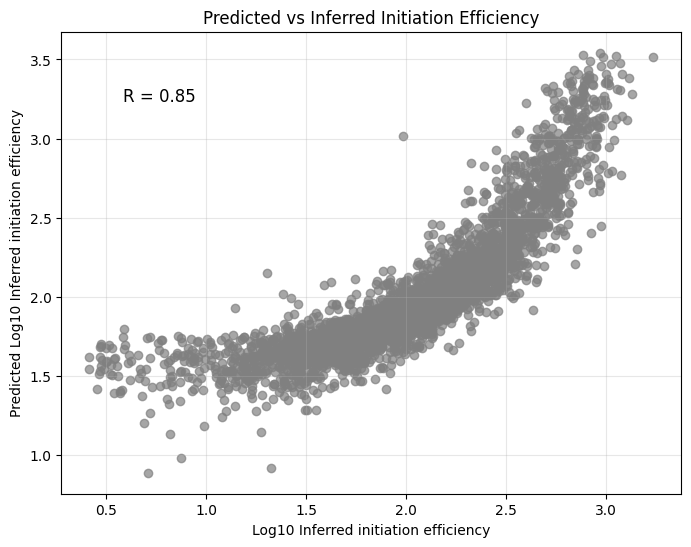

                            OLS Regression Results                            
Dep. Variable:               log10_IE   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     1486.
Date:                Mon, 14 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:14:54   Log-Likelihood:                -272.77
No. Observations:                3348   AIC:                             559.5
Df Residuals:                    3341   BIC:                             602.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.6979      0.023     75.

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


# Define independent and dependent variables
features = ['uAUGs', 'GC_content', 'ORF_length', '5UTR_length', 'folding_energy', 'RiboZero_RPKM']
X = data_df[features]
y = data_df['log10_IE']

# Add a constant and fit the model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Predict and plot
data_df['Predicted_log10_IE'] = model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(data_df['log10_IE'], data_df['Predicted_log10_IE'], color='gray', alpha=0.7)
plt.xlabel('Log10 Inferred initiation efficiency')
plt.ylabel('Predicted Log10 Inferred initiation efficiency')

correlation = np.corrcoef(data_df['log10_IE'], data_df['Predicted_log10_IE'])[0][1]


xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x_coord = xmin + 0.1 * (xmax - xmin)
y_coord = ymax - 0.15 * (ymax - ymin)
plt.text(x_coord, y_coord, f'R = {correlation:.2f}', fontsize=12)


plt.title('Predicted vs Inferred Initiation Efficiency')
plt.grid(alpha=0.3)
plt.show()

print(model.summary())


# OLS without mRNA Abundance (Measuring Total mRNA Contribution in Explaining IE Variance)

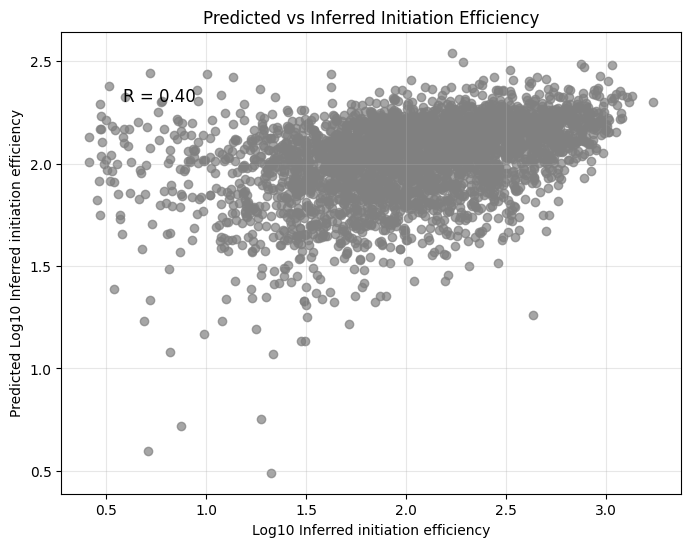

                            OLS Regression Results                            
Dep. Variable:               log10_IE   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     124.1
Date:                Mon, 14 Apr 2025   Prob (F-statistic):          8.00e-121
Time:                        19:15:11   Log-Likelihood:                -2163.9
No. Observations:                3348   AIC:                             4340.
Df Residuals:                    3342   BIC:                             4377.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2132      0.038     57.

In [ ]:
# Define independent and dependent variables
features = ['uAUGs', 'GC_content', 'ORF_length', '5UTR_length', 'folding_energy']
X = data_df[features]
y = data_df['log10_IE']

# Add a constant and fit the model
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Predict and plot
data_df['Predicted_log10_IE'] = model.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(data_df['log10_IE'], data_df['Predicted_log10_IE'], color='gray', alpha=0.7)
plt.xlabel('Log10 Inferred initiation efficiency')
plt.ylabel('Predicted Log10 Inferred initiation efficiency')

correlation = np.corrcoef(data_df['log10_IE'], data_df['Predicted_log10_IE'])[0][1]


xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x_coord = xmin + 0.1 * (xmax - xmin)
y_coord = ymax - 0.15 * (ymax - ymin)
plt.text(x_coord, y_coord, f'R = {correlation:.2f}', fontsize=12)


plt.title('Predicted vs Inferred Initiation Efficiency')
plt.grid(alpha=0.3)
plt.show()

print(model.summary())


# DNN Regression without mRNA abundance

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
def build_model(lambda_value,num_features):
    model = Sequential([
        Dense(64, activation='relu', kernel_regularizer=l2(lambda_value),
              input_shape=(num_features)),
        Dropout(0.2),  # Optional dropout to reduce overfitting
        Dense(32, activation='relu', kernel_regularizer=l2(lambda_value)),
        Dropout(0.2),  # Optional dropout
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


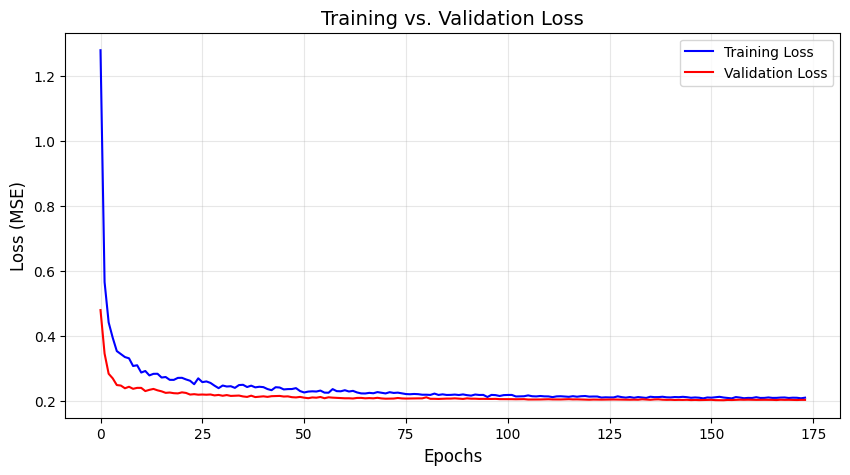

In [ ]:
features = ['uAUGs', 'GC_content', 'ORF_length', '5UTR_length', 'folding_energy']
X = data_df[features]
y = data_df['log10_IE']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Reproducibility setup
np.random.seed(42)
tf.random.set_seed(42)


# Ridge regularization equivalent (adjusted for MSE scaling)
n_samples = X_scaled.shape[0]
lambda_value = 1.0 / (2 * n_samples)  # Ensures appropriate regularization

# Model architecture with Dropout for regularization
model = build_model(lambda_value,(X_scaled.shape[1],))

# Early stopping configuration (monitor validation loss)
early_stop = EarlyStopping(
    monitor='val_loss',  # Prevent overfitting by stopping when val_loss worsens
    patience=20,
    restore_best_weights=True
)


# Model training with validation split
history = model.fit(
    X_scaled, y,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,  # 20% of data used for validation
    callbacks=[early_stop],
    verbose=0
)


# Plot training vs. validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs. Validation Loss', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


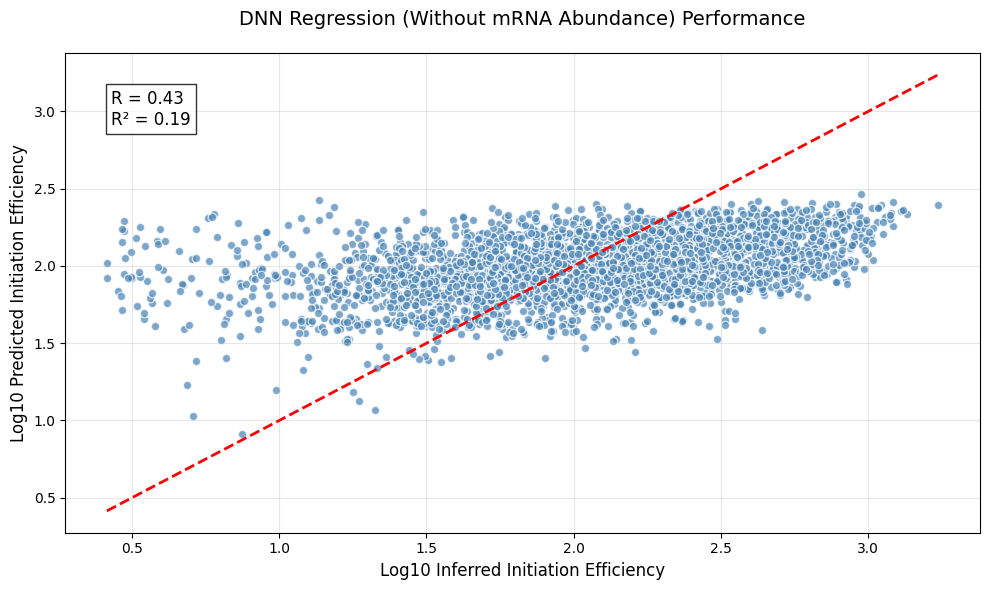

In [ ]:
model=build_model(lambda_value,(X_scaled.shape[1],))

model.fit(
    X_scaled, y,
    epochs=20,
    batch_size=32,
    verbose=0
)

# Generate predictions
y_pred = model.predict(X_scaled).flatten()

# Calculate evaluation metrics
correlation = np.corrcoef(y, y_pred)[0, 1]
r_squared = 1 - np.var(y - y_pred) / np.var(y)

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='steelblue', alpha=0.7, edgecolors='w')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Log10 Inferred Initiation Efficiency', fontsize=12)
plt.ylabel('Log10 Predicted Initiation Efficiency', fontsize=12)
plt.title('DNN Regression (Without mRNA Abundance) Performance', fontsize=14, pad=20)

# Display R² and correlation
plt.text(0.05, 0.85,
         f'R = {correlation:.2f}\nR² = {r_squared:.2f}',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# DNN Regression with All Features (Including mRNA Abundance)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


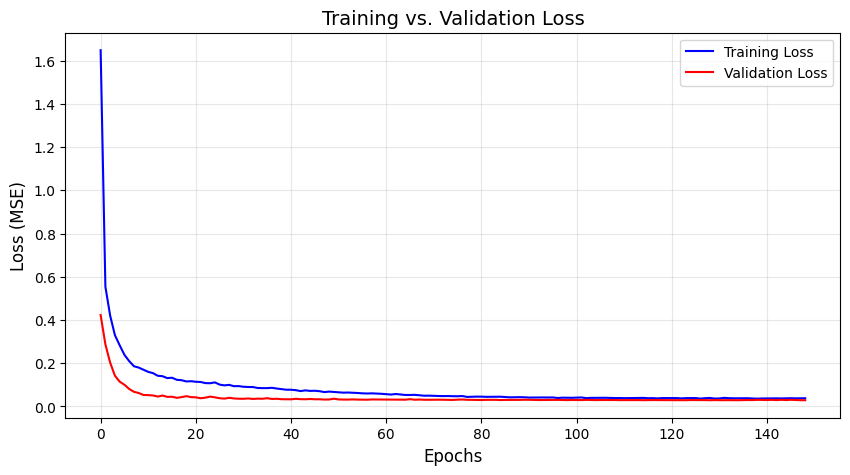

In [ ]:
# Reproducibility setup
np.random.seed(42)
tf.random.set_seed(42)

# Feature selection
features=['uAUGs', 'GC_content','ORF_length', '5UTR_length', 'folding_energy', 'RiboZero_RPKM']
X = data_df[features]
y = data_df['log10_IE']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regularization equivalent (adjusted for MSE scaling)
n_samples = X_scaled.shape[0]
lambda_value = 1.0 / (2 * n_samples)  # Ensures appropriate regularization

# Model architecture with Dropout for regularization
model = build_model(lambda_value,(X_scaled.shape[1],))

# Early stopping configuration (monitor validation loss)
early_stop = EarlyStopping(
    monitor='val_loss',  # Prevent overfitting by stopping when val_loss worsens
    patience=20,
    restore_best_weights=True
)


# Model training with validation split
history = model.fit(
    X_scaled, y,
    epochs=1000,
    batch_size=32,
    validation_split=0.2,  # 20% of data used for validation
    callbacks=[early_stop],
    verbose=0
)


# Plot training vs. validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training vs. Validation Loss', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


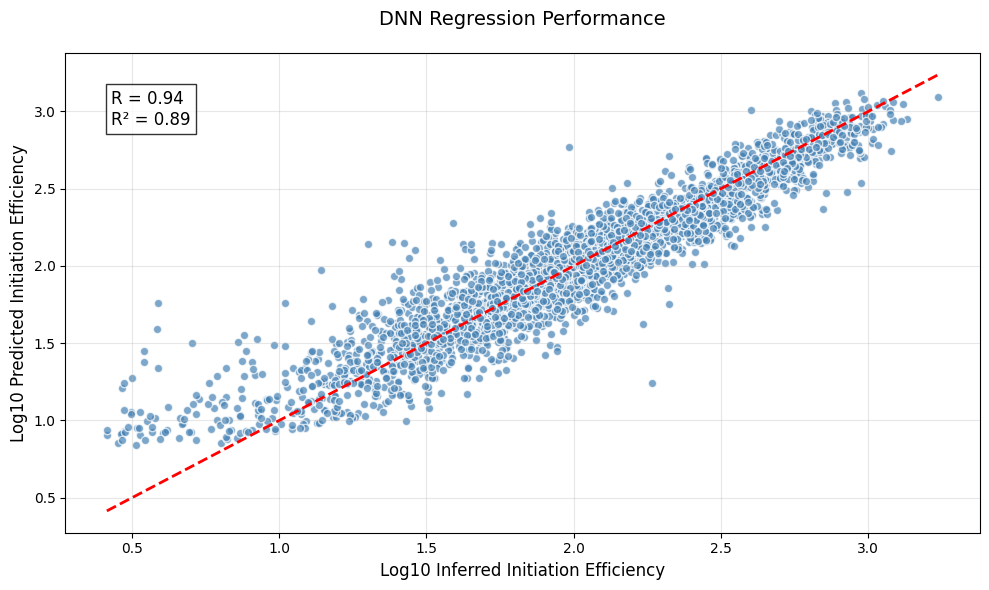

In [ ]:
model=build_model(lambda_value,(X_scaled.shape[1],))

model.fit(
    X_scaled, y,
    epochs=50,
    batch_size=32,
    verbose=0
)

# Generate predictions
y_pred = model.predict(X_scaled).flatten()

# Calculate evaluation metrics
correlation = np.corrcoef(y, y_pred)[0, 1]
r_squared = 1 - np.var(y - y_pred) / np.var(y)

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='steelblue', alpha=0.7, edgecolors='w')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Log10 Inferred Initiation Efficiency', fontsize=12)
plt.ylabel('Log10 Predicted Initiation Efficiency', fontsize=12)
plt.title('DNN Regression Performance', fontsize=14, pad=20)

# Display R² and correlation
plt.text(0.05, 0.85,
         f'R = {correlation:.2f}\nR² = {r_squared:.2f}',
         transform=plt.gca().transAxes,
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
